In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import numpy as np
# import torch
import matplotlib.pyplot as plt

import random
import math


import sklearn
from sklearn.cluster import KMeans

from gsdmm import MovieGroupProcess

import wordninja

import time
import json

# TRY THIS OUT
# https://github.com/nlptown/nlp-notebooks/blob/master/Simple%20Sentence%20Similarity.ipynb


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import re

import spacy
import spacy_sentence_bert

nlp = spacy.load("en_core_web_trf")
# nlp_transform = spacy_sentence_bert.load_model('en_roberta_large_nli_stsb_mean_tokens')

# nltk.download('punkt')
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')


# links to check out
# https://techblog.assignar.com/how-to-use-bert-sentence-embedding-for-clustering-text/
# https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da
# https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1
# https://explosion.ai/blog/spacy-transformers
# https://towardsdatascience.com/installing-tensorflow-with-cuda-cudnn-and-gpu-support-on-windows-10-60693e46e781


In [3]:
file = open("json_data.json")

allprompts = json.load(file)

In [4]:
# obtain word bag

prop_nouns = []
start_words = []
prop_nouns_spec = []

prompt_corpus = []

def get_bag(docs, out_list, word_list):
    # out_list = []

    stop_words = set(stopwords.words("english") + ["etc", "'s", ""])

    for include in ["what", "where", "when", "why", "who", "how"]:
        stop_words.discard(include)
        

    for doc in docs:

        if len(doc[1]) > 0 and len(doc[1][0]) > 0:
            prompt_corpus.append(doc[1])
        
        # separated_words = word_tokenize(doc[1])
        
        tagged_list = nlp(doc[1])

        prop_nouns_spec.append([(X.text, X.label_) for X in tagged_list.ents])
        
        lemmatizer = WordNetLemmatizer()
        lemmatized_list = []

        alpha_regex = re.compile('^[a-zA-Z]+$')

        at_start = True

        prev_prop = False

        for wordtag in tagged_list:

            word = str(wordtag)

            if alpha_regex.match(word):
                if at_start:
                    start_words.append(word)
                    at_start = False

                # if len(word) > 1:
                #     if not consecutiveUpper(word):
                #         split_word = wordninja.split(word)

                #         # print(split_word, word)

                #         if len(split_word) > 1:
                #             word = (split_word[0], wordtag.pos_)

                #             for subword in split_word[1:]:
                #                 tagged_list.append(subword)

                if word not in stop_words:
                    if len(word) > 1:
                        pos = ""
                        if wordtag.pos_ == "PROPN":
                            if prev_prop:
                                prop_nouns[-1] = prop_nouns[-1] + " " + word
                            else:
                                prop_nouns.append(word)
                            prev_prop = True
                        else:
                            prev_prop= False
                        
                        if wordtag.pos_[-1] == "J":
                            pos = "a"
                        elif wordtag.pos_[-1] == "N":
                            pos = "n"
                        elif wordtag.pos_[0] == "V":
                            pos = "v"
                        elif wordtag.pos_[-1] == "V":
                            pos = "r"
                        else:
                            continue

                        lemmatized_list.append(lemmatizer.lemmatize(word, pos=pos))
                        # if lemmatizer.lemmatize(word, pos=pos) == "u":
                        #     print(word, doc)
            else:
                if word in ["?", ".", "!"]:
                    at_start = True
                continue

            word_list += lemmatized_list
            out_list.append(" ".join(lemmatized_list))

        
    return out_list, word_list

In [5]:
word_list = []
numPrompts = []
prompt_corpus_processed = []

for college in allprompts:
    numPrompts.append(len(college[1]))
    
    prompt_corpus_processed, word_list = get_bag(college[1], prompt_corpus_processed, word_list)
    

word_list = set(word_list)

# for word in set(prop_nouns):
#     if word.lower() in word_list:
#         # print(word)
#         word_list.remove(word)

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [89]:
prompt_vectors = []

# i = 0

# print(len(prompt_corpus))
# print(prompt_corpus)
prompt_indices = []
i = 0

for doc in nlp.pipe(prompt_corpus):
    transformed_prompt = doc._.trf_data.tensors[-1]
    if transformed_prompt.shape == (1,768):
        prompt_vectors.append(transformed_prompt[0])
        prompt_indices.append(i)
    i += 1

prompt_matrix = np.stack(prompt_vectors, axis=0)


# prompt_vectors[i]

# print(allprompts[0][1])

# for doc in nlp.pipe(["some text", "some other text"]):
#     tokvecs = doc._.trf_data.tensors[-1]

# tokvecs.shape

In [86]:
print(prompt_vectors[0][0].shape)

(768,)


In [94]:
print(prompt_matrix.shape)

# not sure why but the output matrix is 3D? shape is (1, 768, 941)
# for now, will simply index it here to be 2D

# prompt_matrix_indexed = np.hstack((np.arange(prompt_matrix[0].shape[0])[:, None], prompt_matrix[0]))


prompt_matrix_indexed = np.hstack((np.array(prompt_indices)[:,None], prompt_matrix))

# print(prompt_matrix_indexed.shape)

(941, 768)


In [95]:
prompt_matrix_indexed.shape

(941, 769)

In [26]:
def indToDict(index):
    numPrompts = []
    for prompts in allprompts:
        numPrompts.append(len(prompts[1]))
    
    total = 0
    for x in range(len(numPrompts)):
        curr = numPrompts[x]

        if (total + curr) > index:
            ind = index - total
            return (x, int(ind))
        
        total += curr

In [67]:
indToDict(943)

(299, 1)

In [96]:
pca = PCA(n_components=4)

# pca.fit(prompt_np)

# pca_data = pca.fit_transform(prompt_np_array[:,2:])
pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

pca_data = np.hstack((np.arange(pca_data.shape[0])[:, None], pca_data))

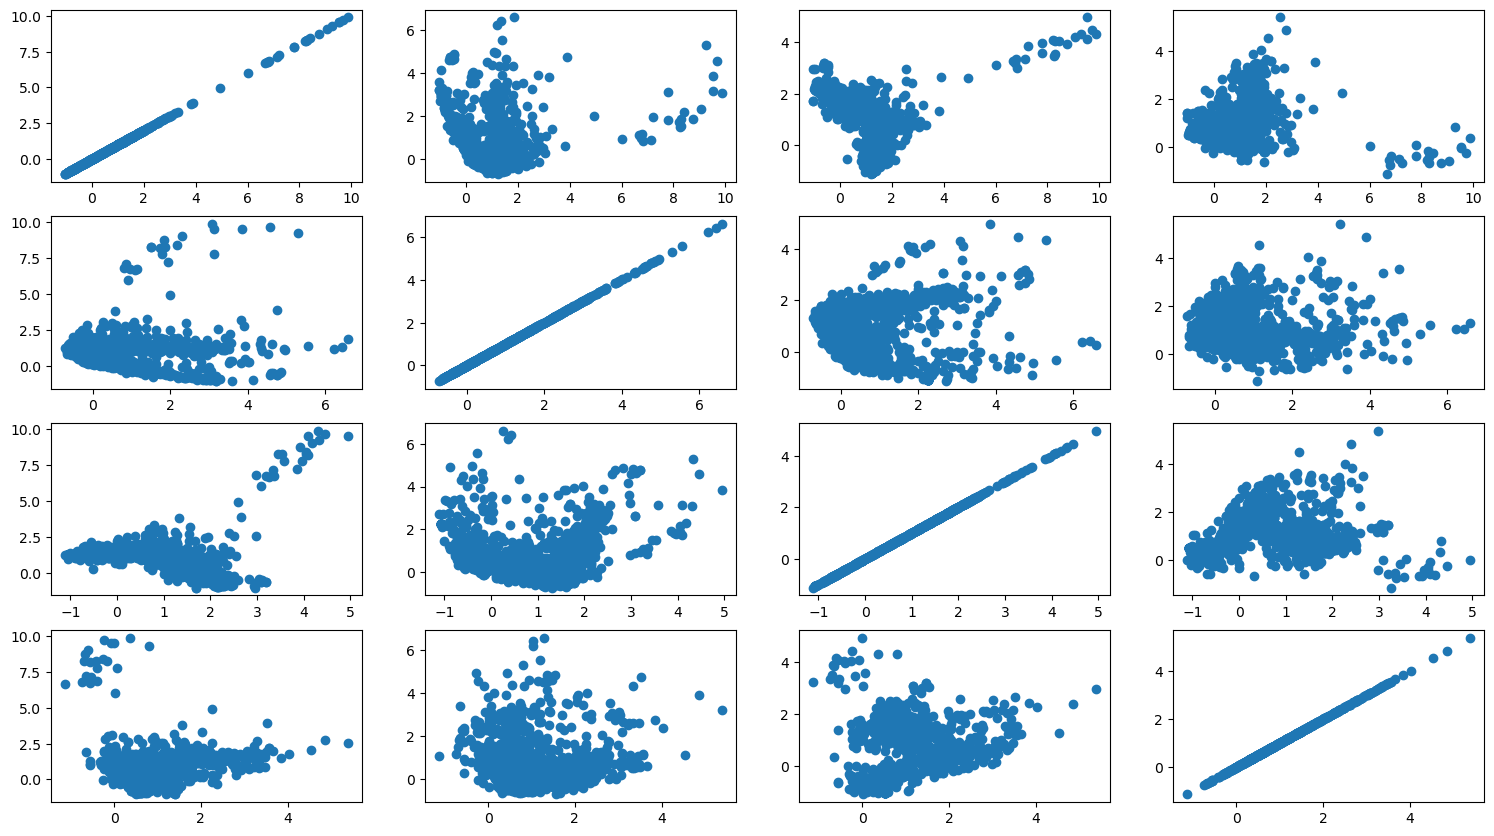

In [97]:
num_comps = pca_data.shape[1]-1

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps+1):
    for j in range(1, num_comps+1):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1)

# plt.setp(axs, xlim=[0.977,1.00], ylim=[0.977,1.00])

plt.show()

In [105]:
pca = PCA(n_components=100)

# pca.fit(prompt_np)

# pca_data = pca.fit_transform(prompt_np_array[:,2:])
pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

pca_data = np.hstack((np.arange(pca_data.shape[0])[:, None], pca_data))

29


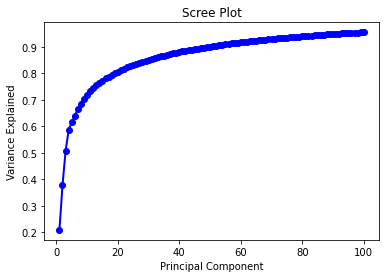

In [106]:
PC_values = np.arange(pca.n_components_) + 1

cumulative_var = [sum(pca.explained_variance_ratio_[0:x+1]) for x in range(len(pca.explained_variance_ratio_))]

i=0
for x in cumulative_var:
    if x > 0.85:
        print(i)
        break
    i+=1
        

plt.plot(PC_values, cumulative_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [107]:
print(sum(pca.explained_variance_ratio_))

0.9553103787929987


In [108]:
# k-means for any dim, points is list of vectors in n-dim

def select_init(points, k, labels):
    random.seed = (333)

    dist_weights = []
    centroids = []

    centroids.append(np.asarray(random.choice(points)))

    while len(centroids) < k:
        dist_weights = find_distances(points, centroids, labels)
        # print()
        centroids.append(np.asarray(random.choices(points, weights=dist_weights)[0]))
    
    # print(centroids)
    return centroids


def find_distances(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]
    closest_dists = []
    # print(centroids)

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            # print(centroids[j][labels:])
            # print(curr_dist, j)
            if curr_dist < min_dist:
                min_dist = curr_dist
        
        closest_dists.append(min_dist)
        # print(min_ind)
        
    return closest_dists


def find_clusters(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        # print(min_ind)
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k, labels = 0):

    # random.seed(133)
    print(labels)

    centroids = select_init(points, k, labels)

    # centroids = random.sample(points, k)

    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    # print(centroids)
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_clusters(points, centroids, labels)
        # print(clusters[0])
        for i in range(k):
            # mean = [0 for x in range(len(points) - labels)]

            # for point_ind in range(1, len(clusters[i])):
            #     mean[point_ind] += clusters[i][point_ind] / len(clusters[i])

            mean = sum(np.asarray(clusters[i])) / len(clusters[i])

            dim = labels
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

1
55


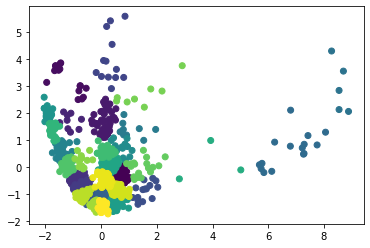

In [113]:
# pca_points = [[pca_data[:,1][i], pca_data[:,2][i]] for i in range(len(pca_data[:,1]))]

pca_points = [list(pca_data[i,0:3]) for i in range(len(pca_data[:,1]))]

# print(pca_points)
num_clusters = 30

pca_clusters = k_means(pca_points, num_clusters, labels = 1)

# EVERYTHING IS IN ONE CLUSTER AHHHHH
print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,1], pca_clusters_graph[:,2], c = pca_clusters_graph[:,3])

In [114]:
n = 2
print(len(pca_clusters[n]))
for point in pca_clusters[n]:
    # print(point[0])
    r, c = indToDict(point[0])

    # print(r, c)

    # print(allprompts[1][1][2])

    print(allprompts[int(r)][1][int(c)])

79
['Stanford Experience Short Response', 'Name one thing you are looking forward to experiencing at Stanford.']
['Extracurricular Short Response', 'Please briefly elaborate on one of your extracurricular activities or work experiences.']
['Select-A-Prompt', 'How you hope to use your college education']
['Select-A-Prompt', 'A list of books you have read during the past twelve months']
['Additional Info Essay', 'There is also one final, open-ended, additional-information text box where you can tell us anything else you think we really ought to know.']
['MMSS Program Short Response', ' Describe your extracurricular interests and activities.']
['ISP Program Essay', 'Please discuss your interest in science and mathematics.']
['ISP Program Essay', 'Briefly discuss your educational and career goals.']
['Extracurricular Short Response', 'Please briefly elaborate on one of your extracurricular activities or work experiences.']
['Select-A-Prompt', 'When was the last time you questioned somethin

In [115]:
# using sklearn KMeans function
elbow = []

for i in range(1, 50):
    # print(i)
    kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 333)
    kmeans.fit(prompt_matrix_indexed[:,1:])
    elbow.append(kmeans.inertia_)

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


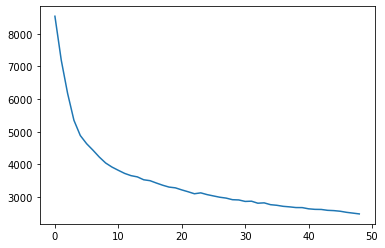

In [116]:
plt.plot(elbow)

In [127]:
kmeans = KMeans(n_clusters = 50, init = "k-means++", random_state = 333)

kmeans.fit(prompt_matrix_indexed[:,1:])

KMeans(n_clusters=50, random_state=333)

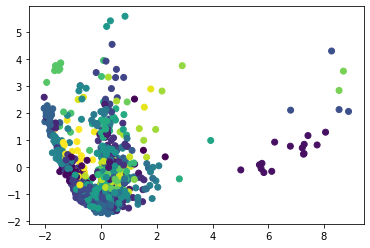

In [145]:
kmeans.labels_.shape

plt.scatter(pca_data[:,1], pca_data[:,2], c = kmeans.labels_)

In [129]:
n = 1

count = 0
for p in range(len(kmeans.labels_)):
    if int(kmeans.labels_[p]) == n:
        r, c = indToDict(p)

        print(allprompts[int(r)][1][int(c)])
        count += 1

print(count)



['Why This College Essay', 'Please share with us why you consider Duke a good match for you. Is there something in particular about Duke’s academic or other offerings that attracts you? ']
[' Nursing and Healthcare Management Essay', " Discuss your interest in nursing and health care management. How might Penn's coordinated dual-degree program in nursing and business help you meet your goals?"]
['Bio-dental Program Short Response', 'What activities have you performed that demonstrate your ability to work cooperatively with people?']
['Select-A-Prompt', 'For you, what makes Cornell Engineering special? Why do you want to attend Cornell Engineering?']
['Why This Major Essay', 'What academic areas are you interested in exploring in college?']
['Social Work Majors Essay', 'Discuss the reasons you chose Social Work as your first-choice major and how a Social Work degree from UT will prepare you for the future.']
['Why This Major Short Response', 'Please explain your interest in your first-c

In [49]:
all_clusters = k_means(prompt_matrix_indexed, 50, labels = 1)

for x in all_clusters:
    print(len(x))

1
10
37
10
6
17
12
27
26
7
7
14
19
9
17
21
17
1
21
23
25
8
12
15
10
16
17
6
18
22
16
8
11
22
22
19
4
11
1
6
16
21
13
36
16
31
15
14
8
19
9


In [54]:
n = 1
for x in all_clusters[n:n+1]:
    print(len(x))

    for i in range(0, len(x)):
        # school_ind = x[i][0]
        # prompt_ind = x[i][1]
        # print(x[i])
        r, c = indToDict(x[i][0])

        # print(r, c)

        # print(allprompts[1][1][2])

        print(allprompts[int(r)][1][int(c)])

# current issue: the vectors are basically just clustering based on their order in rankings
# solutions: 1) randomize word_list order
#            2) uhhhhh why does it still group them by order wtf


37
['Select-A-Prompt', 'What inspires you?\n']
['Select-A-Prompt', 'Yale students embrace the concept of “and” rather than “or,” pursuing arts and sciences, tradition and innovation, defined goals and surprising detours. What is an example of an “and” that you embrace?']
['Graded Paper Requirement', 'Princeton requires you to submit a graded written paper as part of your application. You may submit this material now or any time before the application deadline. If you choose not to upload the required paper at this time, you may mail, e-mail, or upload your paper through the applicant portal. Detailed instructions for our graded paper requirement can be found here.']
['Select-A-Prompt', 'What brings you joy? ']
['Diversity Essay', 'Describe the world you come from; for example, your family, clubs, school, community, city, or town. How has that world shaped your dreams and aspirations?']
['Select-A-Prompt', 'What’s so easy about pie?\n<br />—Inspired by Arjun Kalia, Class of 2025']
['Sel

In [133]:
import hdbscan

cluster_obj = hdbscan.HDBSCAN(min_cluster_size=5, min_samples = 1)

# cluster_obj = hdbscan.HDBSCAN()

cluster_obj.fit(prompt_matrix)

HDBSCAN(min_samples=1)

In [134]:
print(sum([x for x in cluster_obj.labels_ if x == -1]))
print(max(cluster_obj.labels_[0:10]))

-553
19


C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


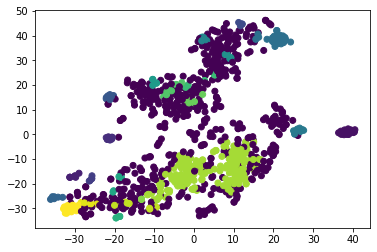

In [137]:
# cluster_obj.probabilities_

# cluster_obj.single_linkage_tree_.plot()

np.random.seed = 222

projection = sklearn.manifold.TSNE().fit_transform(prompt_matrix)
plt.scatter(*projection.T, c=cluster_obj.labels_)

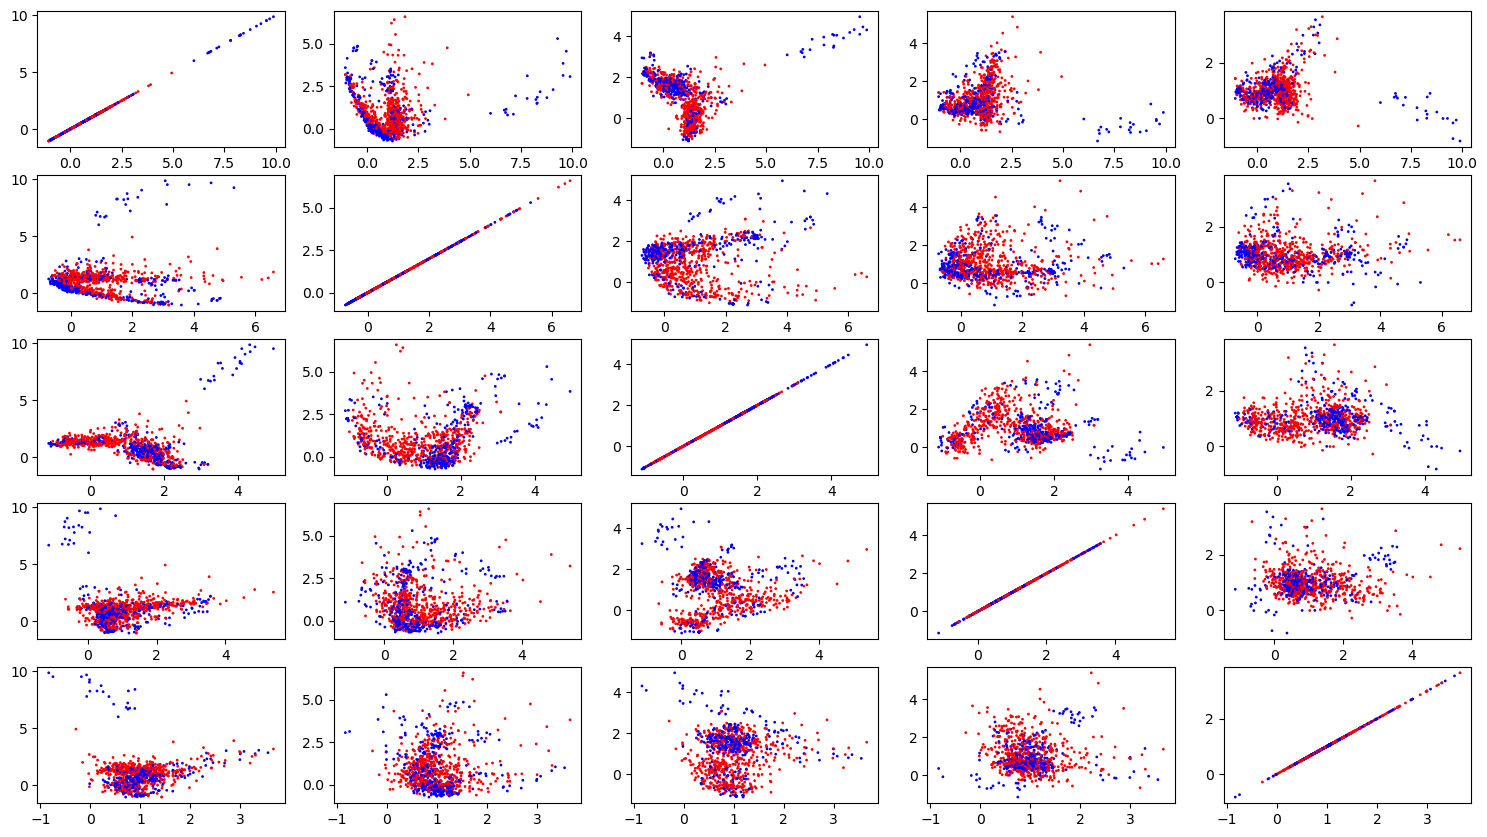

In [139]:
# plt.scatter(pca_clusters_graph[:,0], pca_clusters_graph[:,1], c = cluster_obj.labels_)


#change rhis 
num_comps = 6

fig, axs = plt.subplots(num_comps-1, num_comps-1)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps):
    for j in range(1, num_comps):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1, c = ["red" if x < 0 else "blue" for x in cluster_obj.labels_], s=[1 if x < 0 else 1 for x in cluster_obj.labels_])

In [48]:
# gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=15)

# # fit GSDMM model

# # [x.split() for x in prompt_corpus]

# y = gsdmm.fit(prompt_corpus, len(word_list))

In stage 0: transferred 882 clusters with 13 clusters populated
In stage 1: transferred 76 clusters with 1 clusters populated
In stage 2: transferred 0 clusters with 1 clusters populated
In stage 3: transferred 0 clusters with 1 clusters populated
In stage 4: transferred 0 clusters with 1 clusters populated
In stage 5: transferred 0 clusters with 1 clusters populated
In stage 6: transferred 0 clusters with 1 clusters populated
In stage 7: transferred 0 clusters with 1 clusters populated


KeyboardInterrupt: 